In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler

In [174]:
# 替换路径为你的数据文件路径
data = pd.read_csv("../dataset/food_preprocessed.csv")
data = data[data['人均消费']<=1000]
print(data.head())

   Unnamed: 0  类别 行政区    点评数   口味   环境   服务   人均消费
0           0  烧烤   K  176.0  8.0  8.6  7.9  124.0
1           2  粤菜   K  141.0  6.7  7.2  6.6  141.0
2           3  海鲜   K   76.0  7.2  7.2  7.3  148.0
3           4  烧烤   K  600.0  7.2  7.6  7.0  143.0
4           5  本菜   J   69.0  8.2  8.9  8.4   66.0


In [175]:
features = ["服务", "口味", "环境"]
target = "人均消费" 

X = data[features]
y = data[target]

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train)
# 决策树回归
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train_log)

# 决策树分类
# model = DecisionTreeClassifier(max_depth=5, random_state=42)
# model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [177]:
predictions = np.expm1(model.predict(X_test))

# 回归模型评估
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"均方误差 (MSE): {mse}")
print(f"r2: {r2}")

# 分类模型评估
# accuracy = accuracy_score(y_test, predictions)
# print(f"准确率: {accuracy}")

均方误差 (MSE): 4865.416604358245
r2: 0.2389228012224347


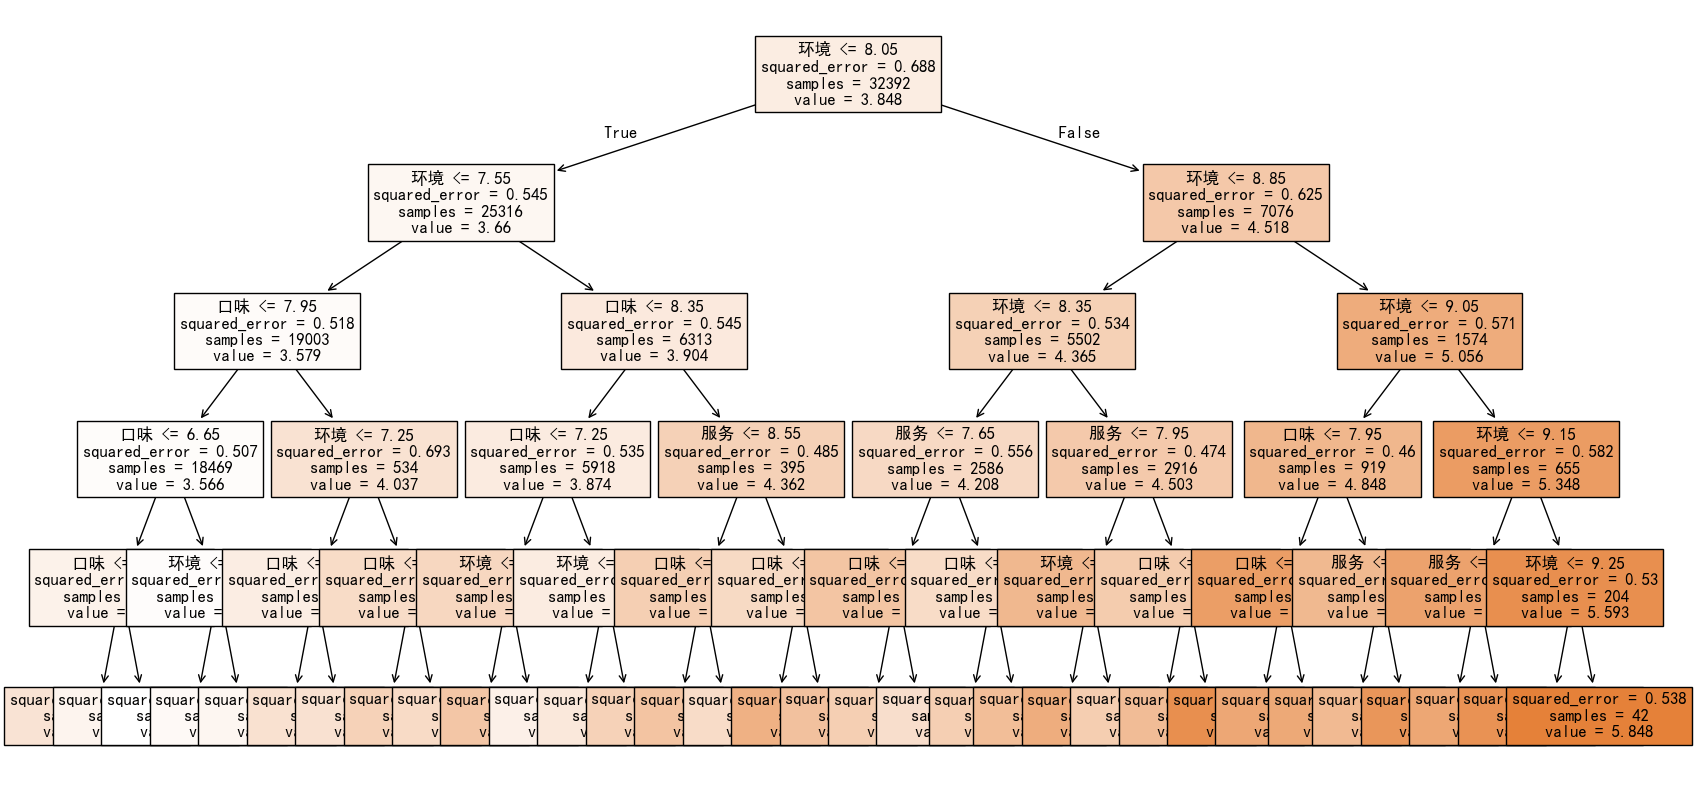

In [178]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=features, filled=True, fontsize=12)
plt.show()

In [179]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def log_inverse_mse(y_true, y_pred_log):
    y_pred = np.expm1(y_pred_log)
    return mean_squared_error(np.expm1(y_true), y_pred)

scorer = make_scorer(log_inverse_mse, greater_is_better=False)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, 
                           cv=5, scoring=scorer
)
grid_search.fit(X_train, y_train_log)

print("最佳参数：", grid_search.best_params_)
best_model = grid_search.best_estimator_

最佳参数： {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [180]:
best_model.fit(X_train, y_train_log)

predictions_best = np.expm1(best_model.predict(X_test))

# 回归模型评估
mse = mean_squared_error(y_test, predictions_best)
r2 = r2_score(y_test, predictions_best)

print(f"均方误差 (MSE): {mse}")
print(f"r2: {r2}")

均方误差 (MSE): 4865.416604358252
r2: 0.2389228012224337


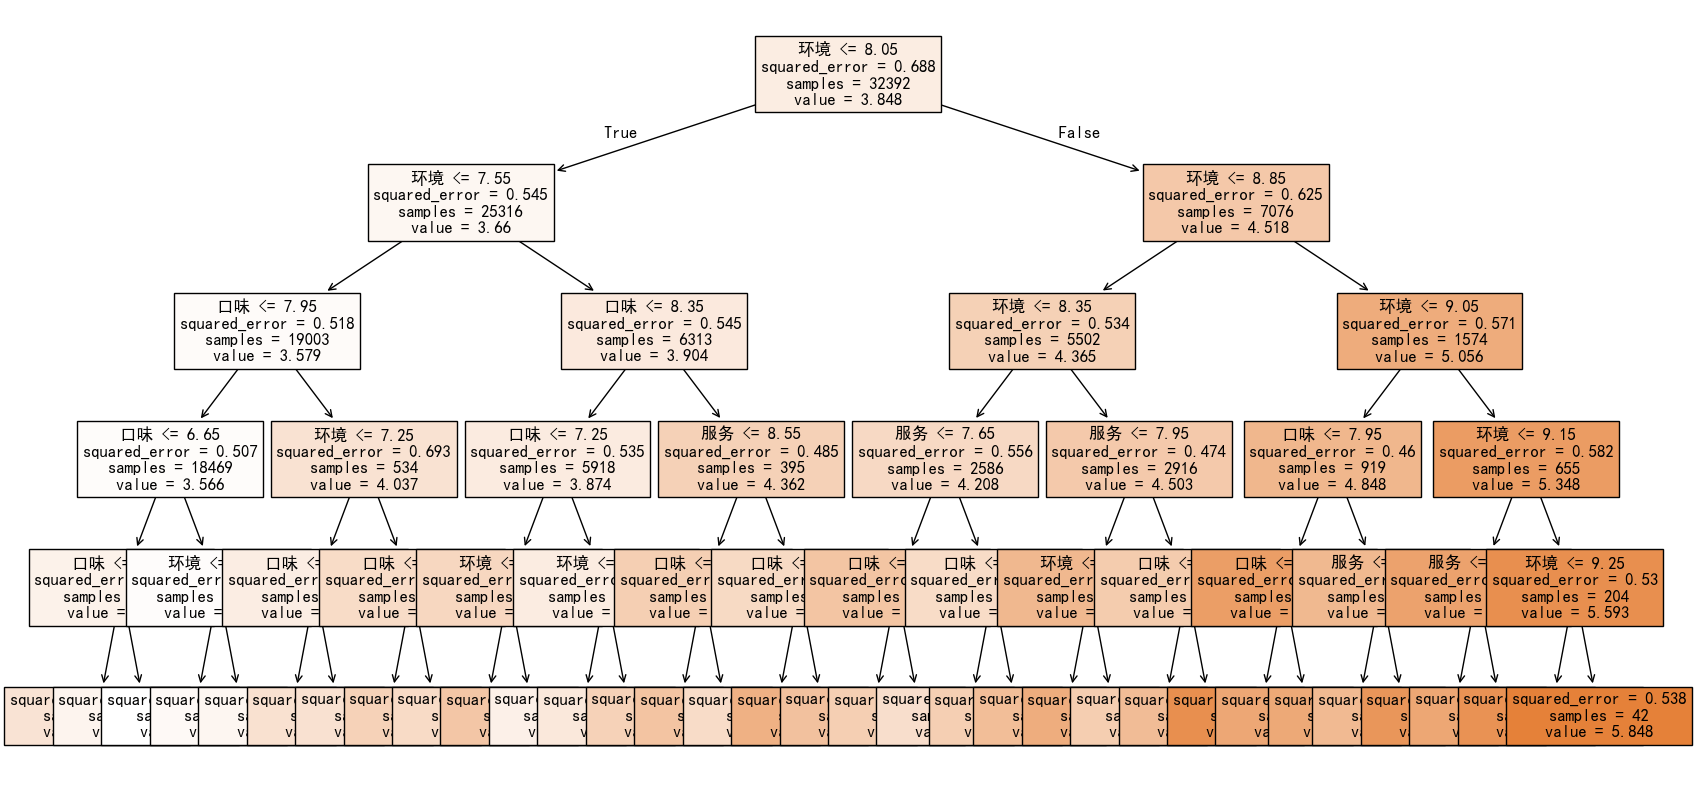

In [181]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=features, filled=True, fontsize=12)
plt.show()

In [182]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train_log)
rf_predictions = np.expm1(rf_model.predict(X_test))
print(f"MSE (随机森林): {mean_squared_error(y_test, rf_predictions)}")

MSE (随机森林): 4949.0321550603085


In [187]:
comparison_df = pd.DataFrame({
    "真实值": y_test,
    "随机森林预测值": rf_predictions,
    "决策树预测值": predictions_best
})

rf_mse = mean_squared_error(comparison_df["真实值"], comparison_df["随机森林预测值"])
dt_mse = mean_squared_error(comparison_df["真实值"], comparison_df["决策树预测值"])
print(f"随机森林 MSE: {rf_mse}")
print(f"决策树 MSE: {dt_mse}")


随机森林 MSE: 4949.0321550603085
决策树 MSE: 4865.416604358252


In [195]:
import altair as alt

x_domain = [comparison_df["真实值"].min(), comparison_df["真实值"].max()]
y_domain = x_domain

x_domain = [comparison_df["真实值"].min(), comparison_df["真实值"].max()]
y_domain = x_domain

# 误差
comparison_df["随机森林误差"] = abs(comparison_df["真实值"] - comparison_df["随机森林预测值"])
comparison_df["决策树误差"] = abs(comparison_df["真实值"] - comparison_df["决策树预测值"])

alt.data_transformers.disable_max_rows()

# 随机森林
rf_chart = (
    alt.Chart(comparison_df)
    .mark_point(filled=True)
    .encode(
        x=alt.X("真实值:Q", scale=alt.Scale(domain=x_domain), title="真实值"),
        y=alt.Y("随机森林预测值:Q", scale=alt.Scale(domain=y_domain), title="预测值"),
        color=alt.Color("随机森林误差:Q", scale=alt.Scale(scheme="redyellowblue"), title="误差"),
        tooltip=["真实值", "随机森林预测值", "随机森林误差"]
    )
    .properties(title="随机森林预测值与真实值比较", width=300, height=300)
)

# 决策树
dt_chart = (
    alt.Chart(comparison_df)
    .mark_point(filled=True)
    .encode(
        x=alt.X("真实值:Q", scale=alt.Scale(domain=x_domain), title="真实值"),
        y=alt.Y("决策树预测值:Q", scale=alt.Scale(domain=y_domain), title="预测值"),
        color=alt.Color("决策树误差:Q", scale=alt.Scale(scheme="redyellowblue"), title="误差"),
        tooltip=["真实值", "决策树预测值", "决策树误差"]
    )
    .properties(title="决策树预测值与真实值比较", width=300, height=300)
)

diagonal = alt.Chart(pd.DataFrame({'x': x_domain, 'y': y_domain})).mark_line(color='black', strokeDash=[5, 5]).encode(
    x='x:Q',
    y='y:Q'
)

comparison_chart = (
    alt.hconcat(
        rf_chart + diagonal,
        dt_chart + diagonal
    )
    .resolve_scale(x="shared", y="shared")
)

comparison_chart.show()

alt.HConcatChart(...)

In [196]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("平均交叉验证得分: ", -scores.mean())

平均交叉验证得分:  4254.052187592583


使用决策树回归模型

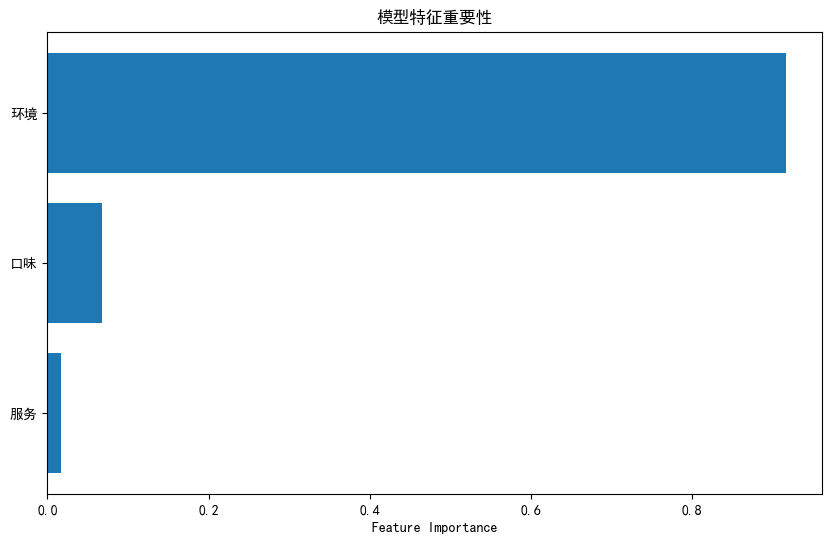

In [197]:
feature_importance = best_model.feature_importances_
# 按长度截取 feature_importance 和 features
sorted_idx = np.argsort(feature_importance)[:len(features)]

# 绘图
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("模型特征重要性")
plt.show()